In [15]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom as di
import pandas as pd
import tensorflow as tf
from PIL import Image

In [41]:
#Fucntion to convert dcm images to nparray of type uint16
def dcm_to_numpy(patient_id, image_id):
    path_to_images = "../images/"
    path_to_images += str(patient_id) + "/" + str(image_id) + ".dcm"
    dcm_image = di.dcmread(path_to_images)
    np_array = dcm_image.pixel_array
    return np_array

#function to save dcm image as png
def save_dcm_as_png(path_to_dcm, png_save_path):
    im = Image.fromarray(dcm_to_numpy(path_to_dcm)*128)
    im.save(png_save_path)

# takes df with info of a single patient and concats the corresponding images into one
def image_concat(patient_df):

    image_array = []
    for image_id in patient_df[patient_df['laterality'] == 'L']['image_id']:
        image_array.append(dcm_to_numpy(patient_df['patient_id'][0], image_id))
    
    row1 = np.concatenate((image_array[0], image_array[1]), axis = 1) # concat L images

    for image_id in patient_df[patient_df['laterality'] == 'R']['image_id']:
        image_array.append(dcm_to_numpy(patient_df['patient_id'][0], image_id))

    row2 = np.concatenate((image_array[0], image_array[1]), axis = 1) # concat R images

    final_image = np.concatenate((row1, row2), axis=0) # concat L and R images

    # im = Image.fromarray(final_image)
    # im = im.convert('RGB')
    # im.save('./concat_images/{}.png'.format(patient_id), compress_level = 1)

    cv2.imwrite('./concat_images/{}.png'.format(patient_df['patient_id'][0]), final_image)

    #####
    # processing is very slow for some reason
    #####

In [25]:
# Loading the CSV file and cleaning the data
train_csv = pd.read_csv(r"../train.csv")
train_csv.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False


In [26]:
train_csv['n_images'] = [0 for _ in range(train_csv.shape[0])]
train_csv['resolution'] = [None for _ in range(train_csv.shape[0])]
train_csv.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0,None
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True,0,None
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False,0,None
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False,0,None
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False,0,None
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False,0,None


In [24]:
train_csv.drop(['n_images', 'resolution'], axis=1).isnull().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [32]:
#Exploring data
print(f"<-- Difficult negative case --> \n {train_csv['difficult_negative_case'].value_counts()}\n")

print(f"<-- Cancer --> \n {train_csv['cancer'].value_counts()}\n")

# The data is very skewed.

<-- Difficult negative case --> 
 False    47001
True      7705
Name: difficult_negative_case, dtype: int64

<-- Cancer --> 
 0    53548
1     1158
Name: cancer, dtype: int64



In [33]:
# Getting a csv of the files we have.
patient_ids_on_hand = []
#Getting the names of the folders at hand.
for file in os.listdir("../images"):
    patient_ids_on_hand.append(int(file))
len(patient_ids_on_hand)

200

In [34]:
# Creating a CSV of images on hand.
csv_data_on_hand = pd.DataFrame(columns=train_csv.columns)

for patient_id in patient_ids_on_hand:
   csv_data_on_hand =  pd.concat([csv_data_on_hand, train_csv[train_csv['patient_id'] == patient_id]])


In [35]:
# Looking at distribution of postivie values.
csv_data_on_hand["cancer"].value_counts()

0    874
1     18
Name: cancer, dtype: int64

In [36]:
csv_data_on_hand['n_images'] = [0 for _ in range(csv_data_on_hand.shape[0])]
csv_data_on_hand['resolution'] = [None for _ in range(csv_data_on_hand.shape[0])]
csv_data_on_hand.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution
102,1,1014,629904228,L,MLO,76.0,0,0,0,1.0,0,B,49,False,0,None
103,1,1014,669597068,L,CC,76.0,0,0,0,1.0,0,B,49,False,0,None
104,1,1014,229558076,R,MLO,76.0,0,0,0,1.0,0,B,49,False,0,None
105,1,1014,1173679750,R,CC,76.0,0,0,0,1.0,0,B,49,False,0,None
110,2,1015,33561657,L,MLO,69.0,0,0,0,NaN,0,NaN,21,False,0,None
111,2,1015,114671324,L,CC,69.0,0,0,0,NaN,0,NaN,21,False,0,None
112,2,1015,864576083,R,CC,69.0,0,0,0,NaN,0,NaN,21,False,0,None
113,2,1015,1622207304,R,MLO,69.0,0,0,0,NaN,0,NaN,21,False,0,None
215,1,1025,773597682,L,CC,56.0,1,1,0,0.0,0,B,49,False,0,None
216,1,1025,1803952236,L,MLO,56.0,1,1,0,0.0,0,B,49,False,0,None


In [51]:
for patient in csv_data_on_hand['patient_id'].unique():
    n_images = 0
    for image in os.listdir('../images/' + str(patient)):
        n_images += 1
        current_image = dcm_to_numpy(patient, image[:-4])
        csv_data_on_hand.loc[csv_data_on_hand['image_id'] == int(image[:-4]), 'resolution'] = f"{current_image.shape[0]} {current_image.shape[1]}"
        # csv_data_on_hand['image_id' == int(image[:-4])]['resolution'] = current_image.shape

    csv_data_on_hand.loc[csv_data_on_hand['patient_id'] == int(patient), 'n_images'] = n_images

In [52]:
csv_data_on_hand.to_csv("csv_data_on_hand.csv")

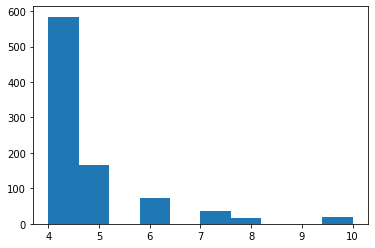

In [53]:
plt.hist(csv_data_on_hand['n_images'])
plt.show()

In [50]:
csv_data_on_hand[csv_data_on_hand['patient_id'] == 1014]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution
102,1,1014,629904228,L,MLO,76.0,0,0,0,1.0,0,B,49,False,4,3328 2560
103,1,1014,669597068,L,CC,76.0,0,0,0,1.0,0,B,49,False,4,3328 2560
104,1,1014,229558076,R,MLO,76.0,0,0,0,1.0,0,B,49,False,4,3328 2560
105,1,1014,1173679750,R,CC,76.0,0,0,0,1.0,0,B,49,False,4,3328 2560


In [ ]:
# iterate over each unique patient id
for patient_id in csv_data_on_hand['patient_id'].unique():
    current_patient = csv_data_on_hand[csv_data_on_hand['patient_id'] == patient_id]
    image_concat(current_patient)